In [1]:
import librosa
import numpy as np
import sys
sys.path.append('../script')

In [2]:
import get_dataset as ds

speech_mel, dialects = ds.load_features(normalised=True)

Getting Ngadas: Marsam.wav 0.9
Getting Ngadas: Mas_Tom_Ngadas_201102.wav 0.0
Getting Banten: JWBP-20121229-A.wav 0.2
Getting Banten: JWBA-20100703-a.wav 0.2
Getting Banten: JWB-Banten_9.wav 0.4
Getting Banten: banten-2010-07-02-a.wav 0.3
Getting Banten: JWB-20090125.wav 0.3
Getting Banten: JWBP-20121229-B.wav 0.0
Getting Banten: JWB-Banten_10.wav 0.1
Getting Banten: JWB-20090126.wav 0.3
Getting Banten: JWB-20090116.wav 0.1
Getting Banten: JWB-Banten20100605-B.wav 0.0
Getting Banten: JWB-Banten_1.wav 0.0
Getting Banten: JWB-Banten_6.wav 0.1
Getting Banten: JWBA-20100703-b.wav 0.1
Getting Banten: JWB-Banten_4.wav 0.0
Getting Banten: JWB-20090117.wav 0.1
Getting Banten: JWB-20090118.wav 0.1
Getting Banten: JWB-Banten_8.wav 0.1
Getting Banten: JWB-20090131.wav 0.5
Getting Banten: JWB-20090130.wav 0.2
Getting Banten: JWB-Banten_11.wav 0.0
Getting Banten: JWB-Banten_5.wav 0.0
Getting Banten: JWB-20090123.wav 0.1
Getting Banten: JWB-20090124.wav 0.1
Getting Banten: JWB-20090127.wav 0.2
Gettin

In [3]:
from pympler.asizeof import asizeof

print('Loaded dataset size in RAM: {a:2.2f}GB'.format(a=asizeof(speech_mel) / 1e9))

Loaded dataset size in RAM: 3.19GB


In [4]:
speech_mel[0].shape

(128, 81857)

In [5]:
dialects[0]

'Ngadas'

In [5]:
# Window split
import preprocessing as pre

speech_mel_split = list()
dialects_split = list()

for feature, dialect in zip(speech_mel, dialects):
    temp = pre.split_window(feature)
    for w in temp:
        speech_mel_split.append(w)
        dialects_split.append(dialect)

# Turning feature to ndarray. Do note that we are adding a dimension; this ensures that TensorFlow reads our feature like how images are supposed to be read: (batch (negligible), x1, x2, channels).
speech_mel_split = np.array(speech_mel_split, dtype=np.float32)[:, :, :, np.newaxis]
dialects_split = np.array(dialects_split)[:, np.newaxis]

# speech_mel = pd.DataFrame(speech_mel_split_list, columns=['feature', 'dialect'])
# speech_mel.head()

In [6]:
print("Mel spectrogram data shape: {}".format(speech_mel_split.shape))
print("Dialects data shape: {}".format(dialects_split.shape))

Mel spectrogram data shape: (38093, 128, 78, 1)
Dialects data shape: (38093, 1)


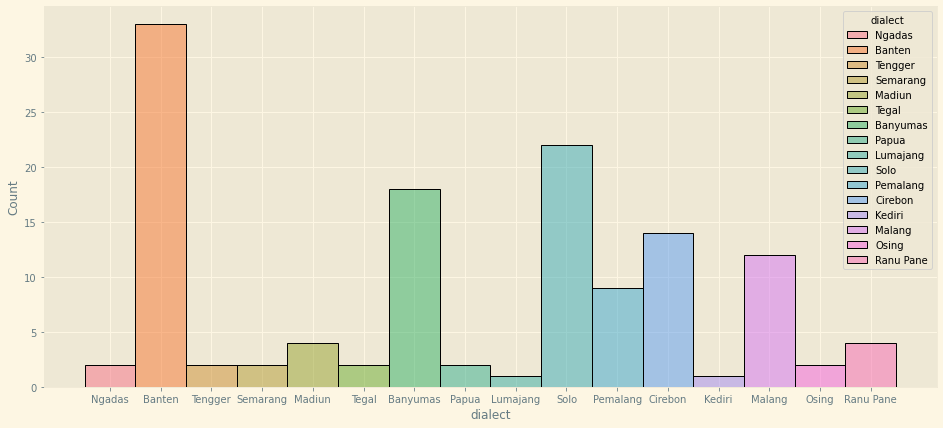

In [7]:
import pandas as pd

# Creating a dialects pandas dataframe for visualization
dialects_df = pd.DataFrame(dialects, columns=['dialect'])

# Full distribution
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('Solarize_Light2')

plt.figure(figsize=(16, 7))
sns.histplot(dialects_df, x='dialect', hue='dialect')

plt.savefig('../visualization/dialect-distribution.png')
plt.show()

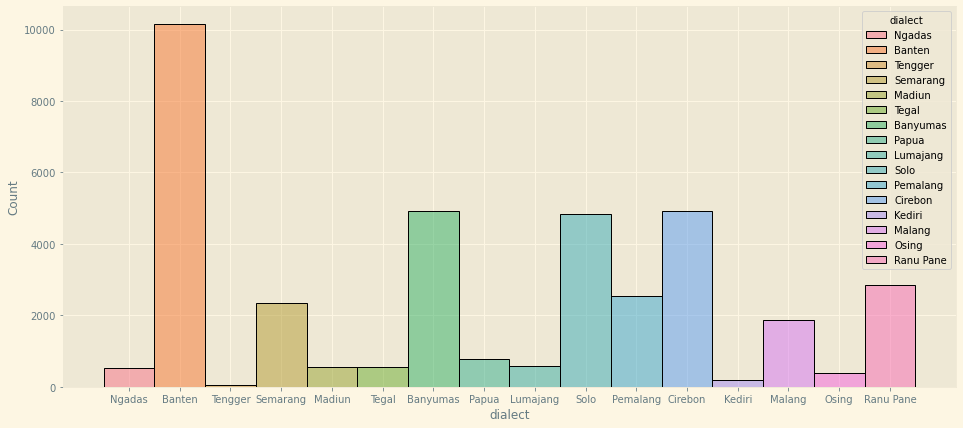

In [8]:
import pandas as pd

# Creating a dialects pandas dataframe for visualization
dialects_split_df = pd.DataFrame(dialects_split, columns=['dialect'])

# Full distribution
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('Solarize_Light2')

plt.figure(figsize=(16, 7))
sns.histplot(dialects_split_df, x='dialect', hue='dialect')

plt.savefig('../visualization/dialect-distribution-windowed.png')
plt.show()

In [9]:
# Cleanup
import gc

# Dataframes
del dialects_df, dialects_split_df

# Loop variables
del temp, dialect, feature, w

# Initial variables
del dialects, speech_mel

gc.collect()

40339

In [10]:
# One-hot encoding of dialects
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(handle_unknown='error')
onehot.fit(dialects_split)

dialects_onehot = onehot.transform(dialects_split).toarray().tolist()
print(dialects_onehot[0])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [11]:
# Test - return a label.

onehot.inverse_transform([dialects_onehot[0]])

array([['Ngadas']], dtype='<U9')

Temporary conclusion: we see that several dialects (such as Tengger, Kediri, or the Osing language) lacks data. We can mitigate this by using resampling by data augmentation (can lead to false positives!) or to dump the dialects instead.

In [12]:
from sklearn.model_selection import train_test_split

X_mel_train, X_mel_test, y_train, y_test = train_test_split(
    speech_mel_split,
    dialects_split,
    train_size=0.8,
    random_state=42
)

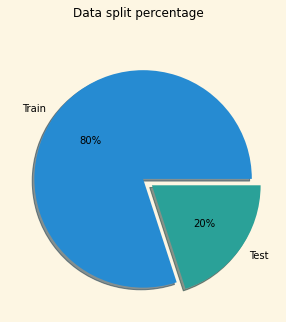

In [13]:
# Distribution of data overall

plt.figure(figsize=(5, 5))
plt.suptitle('Data split percentage')
plt.pie([X_mel_train.shape[0], X_mel_test.shape[0]], explode=[0.0, 0.1], labels=['Train', 'Test'], shadow=True, autopct='%2.f%%')

plt.show()

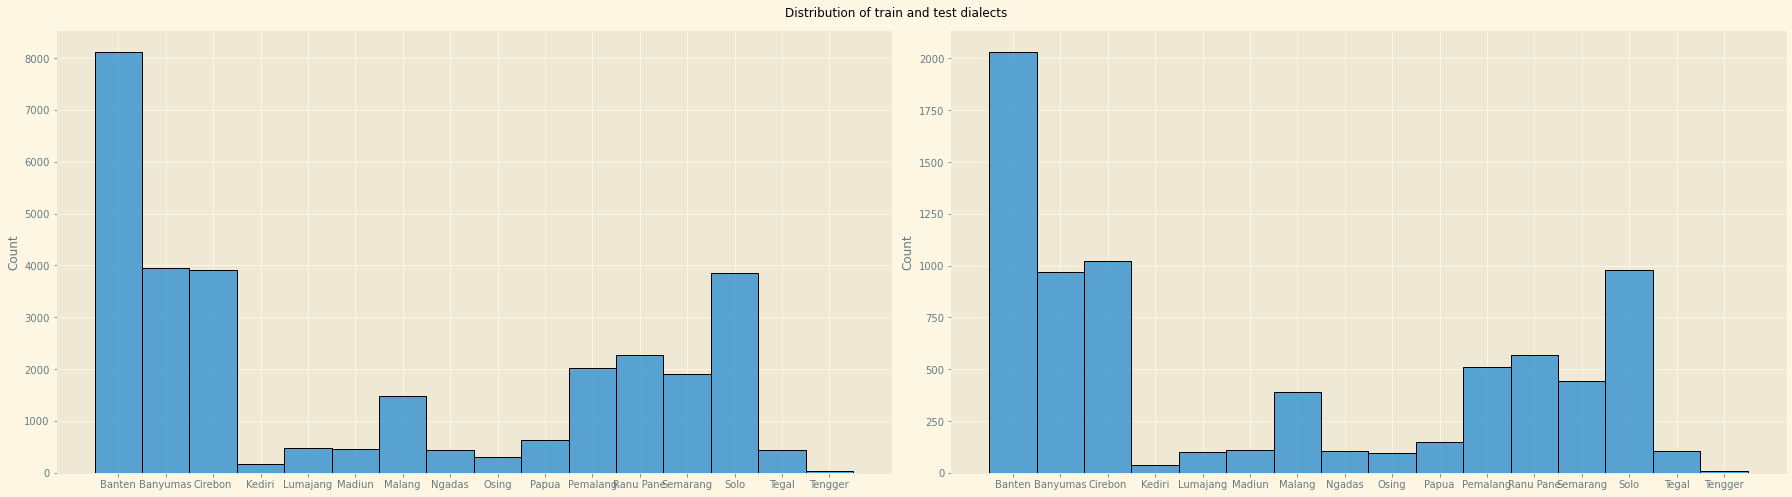

In [14]:
# Presentation of distribution
fig, ax = plt.subplots(1, 2, figsize=(25, 7))
plt.suptitle('Distribution of train and test dialects')

sns.histplot(sorted(y_train.reshape(-1)), ax=ax[0])
sns.histplot(sorted(y_test.reshape(-1)), ax=ax[1])

plt.tight_layout()
plt.savefig('../visualization/distribution-train-test.png')
plt.show()

/tmp/ipykernel_31594/381011803.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


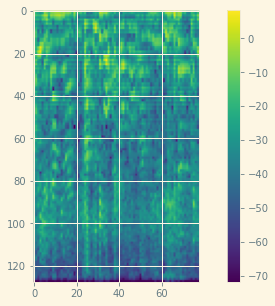

(128, 78, 1)

In [15]:
# Rough illustration
plt.figure(figsize=(10, 5))

plt.imshow(librosa.power_to_db(X_mel_train[0]))
plt.colorbar()
plt.show()

X_mel_train[0].shape

In [16]:
# Now that illustration is done, we are transforming y to one-hot data

y_train = onehot.transform(y_train.reshape((-1, 1))).toarray()
y_test = onehot.transform(y_test.reshape((-1, 1))).toarray()

In [17]:
# Cleaning house.

del fig, ax, dialects_split, speech_mel_split
gc.collect()

17680

In [18]:
import tensorflow as tf

# Checking for GPU availability. If shown none, set up CUDA+cuDNN
tf.config.list_physical_devices('GPU')

2022-01-27 22:37:34.598258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 22:37:34.632727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 22:37:34.632984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
tf.keras.backend.clear_session()

# TODO: add hidden layers, or use dropout
def create_model(feature='mel_spec', arch='cnn'):
    """
    Creates a TensorFlow model.
    :param feature: Audio feature used. Defaults to Mel spectrogram
    :param arch: Neural network architecture used. Defaults to CNN.
    :return: tensorflow.keras.Model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, input_shape=(128, 78, 1)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(256, (3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation=tf.nn.softmax)
    ])
    # Input
    # if feature == 'mel_spec':
    #     model.add(tf.keras.layers.Conv2D)
    # # Arch
    # if arch == 'cnn':
    #     model.add(tf.keras.layers.Conv2D)
    return model

model_mel_spec_cnn = create_model(feature='mel_spec', arch='cnn')
model_mel_spec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 76, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 38, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 36, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 8, 128)       0

2022-01-27 22:37:34.683793: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-27 22:37:34.684506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 22:37:34.684765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 22:37:34.684975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [20]:
import tensorflow_addons as tfa

model_mel_spec_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=16)
    ]
)

In [21]:
# Checkpoint preparation

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../model/checkpoints/model_mel_spectrogram_cnn_nb/',
    save_weights_only=True,
    verbose=1
)

In [22]:
# Training step.

history = model_mel_spec_cnn.fit(
    x=X_mel_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_mel_test, y_test),
    steps_per_epoch=128,
    callbacks=[ckpt_callback]
)

2022-01-27 22:37:35.315212: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1217009664 exceeds 10% of free system memory.
2022-01-27 22:37:35.986140: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1217009664 exceeds 10% of free system memory.


Epoch 1/50


2022-01-27 22:37:38.057646: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


127/128 [============================>.] - ETA: 0s - loss: 2.4520 - categorical_accuracy: 0.2405 - precision: 0.5594 - recall: 0.0440 - f1_score: 0.0463
Epoch 00001: saving model to ../model/checkpoints/model_mel_spectrogram_cnn_nb/
128/128 [==============================] - 8s 43ms/step - loss: 2.4513 - categorical_accuracy: 0.2404 - precision: 0.5588 - recall: 0.0441 - f1_score: 0.0463 - val_loss: 2.1676 - val_categorical_accuracy: 0.2810 - val_precision: 0.7180 - val_recall: 0.0545 - val_f1_score: 0.0504
Epoch 2/50
127/128 [============================>.] - ETA: 0s - loss: 2.1730 - categorical_accuracy: 0.2712 - precision: 0.6508 - recall: 0.0709 - f1_score: 0.0636
Epoch 00002: saving model to ../model/checkpoints/model_mel_spectrogram_cnn_nb/
128/128 [==============================] - 5s 38ms/step - loss: 2.1724 - categorical_accuracy: 0.2711 - precision: 0.6506 - recall: 0.0709 - f1_score: 0.0638 - val_loss: 2.0157 - val_categorical_accuracy: 0.3019 - val_precision: 0.7792 - val_r

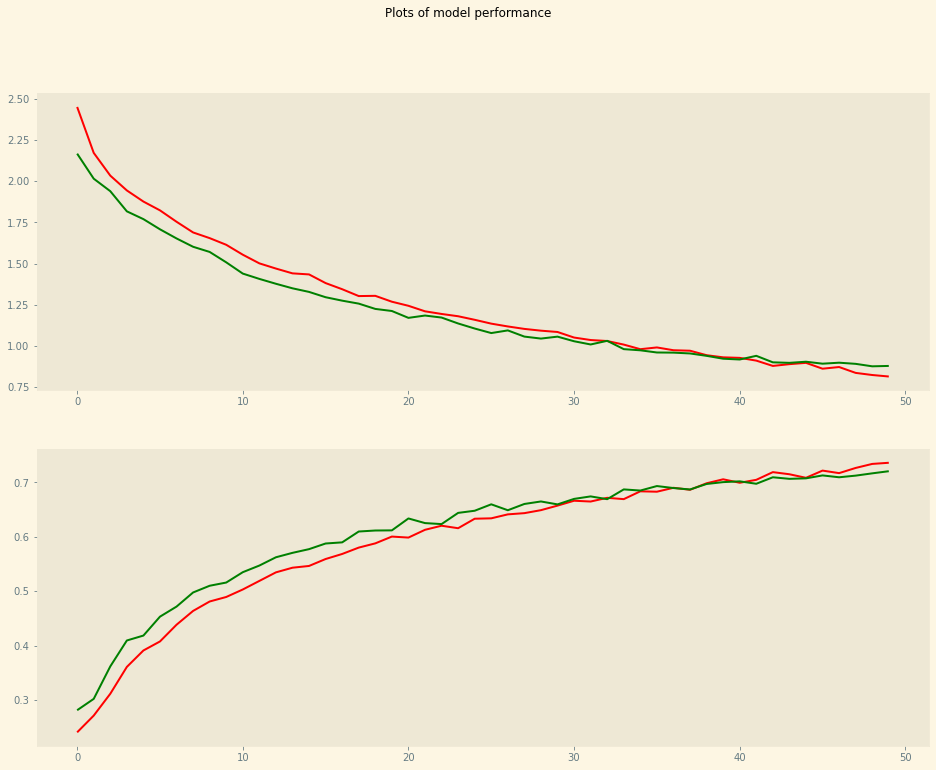

In [23]:
# Model visualisation - for now

fig, ax = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('Plots of model performance')

ax[0].plot(history.history['loss'], 'r')
ax[0].plot(history.history['val_loss'], 'g')
ax[1].plot(history.history['categorical_accuracy'], 'r')
ax[1].plot(history.history['val_categorical_accuracy'], 'g')
ax[0].grid()
ax[1].grid()

plt.savefig('../visualization/1-model-performance.png')
plt.show()

In [24]:
# TODO: data augmentation, regularisation

In [25]:
onehot.categories_[0][0]

'Banten'

In [26]:
metrics = model_mel_spec_cnn.evaluate(X_mel_test, y_test)
print("""Model training validation result:
Loss\t\t: {},
Accuracy\t: {},
Precision\t: {},
Recall\t\t: {},

F1 score per categories:""".format(
    metrics[0], metrics[1], metrics[2], metrics[3]
))
for i in range(len(metrics[4])):
    print('\t' + onehot.categories_[0][i] + ':', str(metrics[4][i]))

239/239 [==============================] - 2s 7ms/step - loss: 0.8785 - categorical_accuracy: 0.7206 - precision: 0.8194 - recall: 0.6164 - f1_score: 0.5405
Model training validation result:
Loss		: 0.8784595727920532,
Accuracy	: 0.720566987991333,
Precision	: 0.8194032311439514,
Recall		: 0.6163538694381714,

F1 score per categories:
	Banten: 0.79122543
	Banyumas: 0.6023875
	Cirebon: 0.802139
	Kediri: 0.29166666
	Lumajang: 0.58767766
	Madiun: 0.42201835
	Malang: 0.51241535
	Ngadas: 0.19847329
	Osing: 0.41269842
	Papua: 0.5754717
	Pemalang: 0.7450272
	Ranu Pane: 0.79061687
	Semarang: 0.8294737
	Solo: 0.7709678
	Tegal: 0.31496063
	Tengger: 0.0


In [27]:
# Saving model.
model_mel_spec_cnn.save('../model/model_mel_spec_cnn_nb')
model_mel_spec_cnn.save_weights('../model/weights/model_mel_spec_cnn_nb/')

2022-01-27 22:41:45.140341: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model/model_mel_spec_cnn_nb/assets
